In the following notebook we will show how you can use the CARLA library for causal recourse methods.

# Causal Recourse

## Data

Before we can do anything else we need some data, and more importantly a data generating process.
We define this process by the Structural Causal Equations (SCM).
In CARLA can be easily done by just calling the *CausalModel* class with the name of the SCM you want to use.
Note that you can add your own SCM's by adding it's name to the *scm_dict* in carla/data/load_scm/load_scm and defining the equations in carla/data/load_scm/scm.

In [1]:
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

from carla.data.causal_model import CausalModel

Using TensorFlow backend.


[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]
[WARNING] From /home/johan/Dropbox/Documents/Master/HiWi/CARLA/carla/recourse_methods/catalog/focus/distances.py:2: The name tf.losses.Reduction is deprecated. Please use tf.compat.v1.losses.Reduction instead.
 [deprecation_wrapper.py __getattr__]


In [2]:
scm = CausalModel("sanity-3-lin")
dataset = scm.generate_dataset(10000)

display(dataset.df)

,label,x1,x2,x3
0,0.0,-2.170740,1.611900,-0.000079
1,0.0,2.367498,-2.104416,-0.248596
2,0.0,1.684761,-2.919451,-1.002269
3,1.0,-2.192833,2.875651,0.526477
4,1.0,3.333677,-3.877350,-1.312688
...,...,...,...,...
9995,1.0,-1.267951,0.954710,-0.558307
9996,1.0,2.450825,-1.657112,0.300450
9997,0.0,1.721105,-1.271317,-0.649411
9998,0.0,0.881236,-1.813018,0.295015


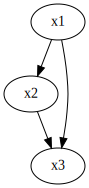

In [3]:
scm.cgm.draw()

## Model

Now that we have the data loaded we also need a classification model.
You could define your own [model](https://carla-counterfactual-and-recourse-library.readthedocs.io/en/latest/examples.html#black-box-model),
however here we will show how you can train one of our [catalog](https://carla-counterfactual-and-recourse-library.readthedocs.io/en/latest/mlmodel.html#module-models.catalog.catalog) models.
Note that depending on your data you might need to tweak the training hyperparameters.

In [4]:
from carla.models.catalog import MLModelCatalog

In [5]:
training_params = {"lr": 0.01, "epochs": 10, "batch_size": 16, "hidden_size": [18, 9, 3]}

ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
)
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)

balance on test set 0.5141333333333333, balance on test set 0.5272
Epoch 0/9
----------
train Loss: 0.3865 Acc: 0.8229

test Loss: 0.3775 Acc: 0.8268

Epoch 1/9
----------
train Loss: 0.3736 Acc: 0.8273

test Loss: 0.3694 Acc: 0.8304

Epoch 2/9
----------
train Loss: 0.3732 Acc: 0.8297

test Loss: 0.3702 Acc: 0.8300

Epoch 3/9
----------
train Loss: 0.3720 Acc: 0.8313

test Loss: 0.3702 Acc: 0.8296

Epoch 4/9
----------
train Loss: 0.3714 Acc: 0.8295

test Loss: 0.3698 Acc: 0.8300

Epoch 5/9
----------
train Loss: 0.3715 Acc: 0.8305

test Loss: 0.3692 Acc: 0.8316

Epoch 6/9
----------
train Loss: 0.3702 Acc: 0.8341

test Loss: 0.3824 Acc: 0.8268

Epoch 7/9
----------
train Loss: 0.3708 Acc: 0.8303

test Loss: 0.3689 Acc: 0.8308

Epoch 8/9
----------
train Loss: 0.3719 Acc: 0.8305

test Loss: 0.3687 Acc: 0.8308

Epoch 9/9
----------
train Loss: 0.3701 Acc: 0.8327

test Loss: 0.3675 Acc: 0.8308



## Recourse

Now that we have both the data, and a model we can start using CARLA to generate counterfactuals.
In the following example we are getting negative labeled samples for which we want counterfactuals.

In [6]:
from carla.models.negative_instances import predict_negative_instances
from carla.recourse_methods.catalog.causal_recourse import (
    CausalRecourse,
    constraints,
    samplers,
)

In [7]:
# get factuals
factuals = predict_negative_instances(ml_model, dataset.df)
test_factual = factuals.iloc[:5]

In [8]:
hyperparams = {
    "optimization_approach": "brute_force",
    "num_samples": 10,
    "scm": scm,
    "constraint_handle": constraints.point_constraint,
    "sampler_handle": samplers.sample_true_m0,
}
cfs = CausalRecourse(ml_model, hyperparams).get_counterfactuals(test_factual)

display(cfs)


,x2,x1,x3
0,4.875700,-2.170740,-0.000079
1,-2.899361,1.684761,-1.002269
2,-7.100980,7.913797,-1.312688
3,-0.499893,0.684368,-2.310247
4,-1.516558,0.116863,0.610931
